In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import finite
import timesteppers
from IPython.display import display, clear_output
import scipy.sparse.linalg as spla
from scipy import sparse

In [3]:
def plot_2D_field(xm, ym, data):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    pcm = ax.pcolormesh(xm, ym, data)
    ax.set_aspect(1)
    fig.colorbar(pcm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.tight_layout()

def plot_2D(matrix):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()

## Diffusion Problem

As an example of a problem we can solve with implicit timestepping, we will solve the 2D diffusion problem
$$\partial_t c - D \nabla^2 c = \partial_t c - D (\partial_x^2 + \partial_y^2) c = 0.$$
We will use operator splitting and solve these two equations separately:
$$\partial_t c - D \partial_x^2 c = 0$$
$$\partial_t c - D \partial_y^2 c = 0$$

In [4]:
class Diffusionx:
    
    def __init__(self, c, D, d2x):
        self.X = timesteppers.StateVector([c], axis=0)
        N = c.shape[0]
        self.M = sparse.eye(N, N)
        self.L = -D*d2x.matrix


class Diffusiony:
    
    def __init__(self, c, D, d2y):
        self.X = timesteppers.StateVector([c], axis=1)
        N = c.shape[1]
        self.M = sparse.eye(N, N)
        self.L = -D*d2y.matrix

In [5]:
N = 200
grid_x = finite.UniformPeriodicGrid(N, 20)
grid_y = finite.UniformPeriodicGrid(N, 20)
domain = finite.Domain((grid_x, grid_y))
x, y = domain.values()
xm, ym = domain.plotting_arrays()

r = np.sqrt((x-10)**2 + (y-10)**2)

IC = np.exp(-r**2/4)
# t = 2, so evolve forward for 1 unit
target = 1/2*np.exp(-r**2/8)

In [19]:
c = np.zeros(domain.shape)
c[:] = IC
d2x = finite.DifferenceUniformGrid(2, 4, grid_x, 0)
d2y = finite.DifferenceUniformGrid(2, 4, grid_y, 1)
D = 1
diffx = Diffusionx(c, D, d2x)
diffy = Diffusiony(c, D, d2y)
ts_x = timesteppers.CrankNicolson(diffx, 0)
ts_y = timesteppers.CrankNicolson(diffy, 1)
alpha = 0.125
dt = alpha*grid_x.dx

<ufunc 'solve1'>
<ufunc 'solve1'>


In [20]:
def step_xy(dt):
    ts_y.step(dt)
    ts_x.step(dt)

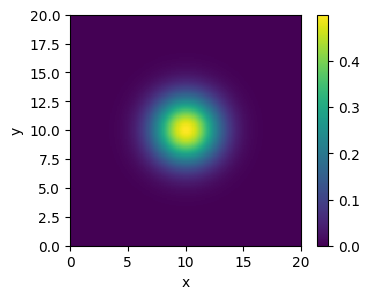

-1.5543122344752192e-15


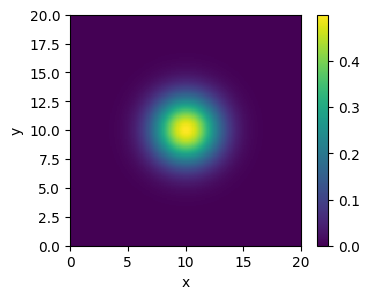

In [21]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(xm, ym, c.data)
ax.set_aspect(1)
fig.colorbar(pcm)
ax.set_xlabel('x')
ax.set_ylabel('y')
while ts_x.t < 1 - 1e-5:
    step_xy(dt)
    if ts_x.iter % 1 == 0:
        pcm.set_array(np.ravel(c.data))
        pcm.set_clim([0,np.max(c.data)])
        clear_output(wait=True)
        display(fig)
print(ts_x.t - 1)

In [22]:
# alpha = 0.125
np.max(np.abs(c.data - target))

np.float64(2.7918052977193852e-06)

In [9]:
# alpha = 0.125*2
np.max(np.abs(c.data - target))

np.float64(1.1947998419636896e-05)

In [23]:
2.7918052977193852e-06*4

1.1167221190877541e-05